In [1]:
#%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hankel2, erfc, jv
from ipywidgets import interactive, fixed
from IPython.display import display

In [2]:
# sears function from hankel functions
def Sears(x):
    h1_2=hankel2(1,x)
    h0_2=hankel2(0,x)
    h_=h0_2-1j*h1_2

    S=2/(np.pi*x*h_)
    return S

# A class that calculates intermediate values and response functions
class amietResponse:

    def __init__(self, Kx_bar, M):
        self.Kx_bar=Kx_bar
        self.M=M
        self.Beta=np.sqrt(1-M**2)       # Prandtl-Glauert
        self.mu_bar=self.M*self.Kx_bar/self.Beta**2

        self.f_M=(1-self.Beta)*np.log(self.M)+self.Beta*np.log(1+self.Beta)-np.log(2)
        self.Kx_star_bar=self.Kx_bar/self.Beta**2

        self.sigma=None

    def g(self,x_bar):

        g = (1/np.pi/self.Beta*np.sqrt((1-x_bar)/(1+x_bar))*Sears(self.Kx_star_bar)*
             np.exp(1j*self.Kx_star_bar*(self.M**2*x_bar+self.f_M)))

        return g

    def g1_g2(self,x_bar):
        Theta=self.mu_bar*(1-self.M)*(1+x_bar)+np.pi/4-self.Kx_bar
        # borrowing Moreau conversion from Fresnel to erfc
        i_plus_1_times_E_star_minus_1=lambda x:-erfc((1+1j)*np.emath.sqrt(x/2))

        g1 = 1/(np.pi*np.sqrt(np.pi*(1+self.M)*self.Kx_bar*(1+x_bar)))*np.exp(-1j*Theta)

        g2 = ( 1/(np.pi*np.sqrt(2*np.pi*(1+self.M)*self.Kx_bar))*
              (i_plus_1_times_E_star_minus_1(2*self.mu_bar*(1-x_bar)))*
              np.exp(-1j*Theta) )

        return g1+g2

    def L(self,xyz):
        if self.sigma is None:
            self.sigma=(np.sqrt(xyz[:,0]**2 + self.Beta**2*(xyz[:,1]**2+xyz[:,2]**2)))
        x_over_sigma = xyz[:,0] / self.sigma

        L=( Sears(self.Kx_star_bar)*np.exp(1j*self.Kx_star_bar*self.f_M)/self.Beta*
                (jv(0,self.mu_bar*x_over_sigma)-1j*jv(1,self.mu_bar*x_over_sigma)) )
        return L

    def L1_L2(self,xyz):
        if self.sigma is None:
            self.sigma=(np.sqrt(xyz[:,0]**2 + self.Beta**2*(xyz[:,1]**2+xyz[:,2]**2)))
        x_over_sigma = xyz[:,0] / self.sigma
        Theta1=self.mu_bar*(1-x_over_sigma)
        Theta2=self.Kx_star_bar*(1-self.M*x_over_sigma) - np.pi/4

        E_star=lambda x:(1-erfc((1+1j)*np.emath.sqrt(x/2)))/(1+1j)

        L1=( np.sqrt(2)*E_star(2*Theta1)*np.exp(1j*Theta2)/
            (np.pi*np.sqrt(self.Kx_bar*(1+self.M)*Theta1)) )

        L2=( np.exp(1j*Theta2)* (1j*(1-np.exp(-2j*Theta1))+(1-1j)*
            E_star(4*self.Kx_bar*self.M)-np.sqrt(2)*np.exp(-2j*Theta1)*
            E_star(2*self.mu_bar*(1+x_over_sigma))/
            np.sqrt(1+1*x_over_sigma)) / (np.pi*Theta1*
            np.sqrt(2*np.pi*self.Kx_bar*(1+self.M))) )

        return L1+L2

In [3]:
def plot_gs(x_bar,Kx_bar=0.2,M=0.1):

  # initialize the class with omega, M, chord
  f=amietResponse(Kx_bar,M)

  g=f.g(x_bar)

  g1_g2=f.g1_g2(x_bar)

  fig, ax = plt.subplots()
  ax.plot(x_bar, np.real(g),color='royalblue',label="Low-Frequency (g)")
  ax.plot(x_bar, np.real(g1_g2),color='crimson',label="High-Frequency (g1+g2)")
  plt.ylim(-1,2)
  plt.xlim(-1,1)
  plt.xlabel(r"Normalized Chord ($\overline{x}$)", fontsize=14)
  plt.ylabel("Response function Real Component", fontsize=14)
  plt.title(fr"$\overline{{\mu}}$={f.mu_bar:.3f}")
  plt.legend(fontsize=12)
  ax.grid(True)
  plt.show()

def plot_pTs(xyz,Kx_bar=0.2,M=0.1,chord=1.0):
  b=chord/2
  # initialize the class with omega, M, chord
  f=amietResponse(Kx_bar,M)

  L=f.L(xyz)
  pT=1j*np.pi*b*Kx_bar*xyz[:,-1]/f.sigma**2*L*np.exp(1j*f.mu_bar*b*(M*xyz[:,0]-f.sigma))

  pT12=1j*np.pi*b*Kx_bar*xyz[:,-1]/f.sigma**2*f.L1_L2(xyz)*np.exp(1j*f.mu_bar*b*(M*xyz[:,0]-f.sigma))

  plt.figure()
  fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
  ax.plot(theta, np.abs(pT),color='royalblue',label="Low-Frequency (L)")
  ax.plot(theta, np.abs(pT12),color='crimson',label="High-Frequency (L1+L2)")
  plt.title(fr"$\overline{{\mu}}$ = {f.mu_bar:.2f}")
  plt.legend(fontsize=12)
  ax.grid(True)
  plt.tight_layout()
  plt.show()

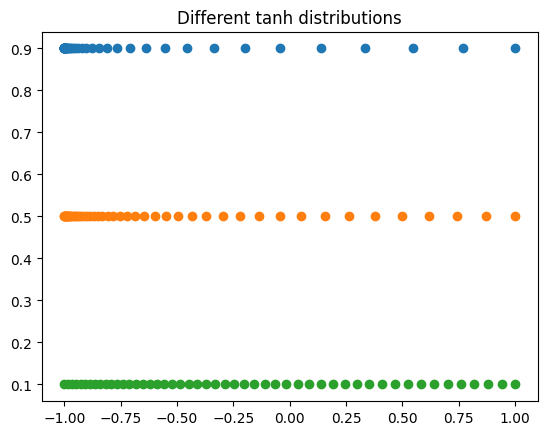

In [4]:
tanh_dist=lambda x:(1-np.tanh(x*np.linspace(0,2*np.pi, num=50)) / np.tanh(x * 2*np.pi)) * 2 - 1

plt.figure()
plt.scatter(tanh_dist(0.9),np.ones(50)*0.9)
plt.scatter(tanh_dist(0.5),np.ones(50)*0.5)
plt.scatter(tanh_dist(0.2),np.ones(50)*0.1)
plt.title("Different tanh distributions")
plt.show()

In [5]:
# points along airfoil
#x_bar=np.linspace(-0.99,1,50)
tanh_dist=lambda x:(1-np.tanh(x*np.linspace(2*np.pi,0, num=51)) / np.tanh(x * 2*np.pi)) * 1.9999  -0.9999

x_bar=tanh_dist(0.2)
chord=1

w=interactive(plot_gs, x_bar=fixed(x_bar), Kx_bar=(1,50,5), M=(0.01,0.91,0.1))
display(w)

interactive(children=(IntSlider(value=1, description='Kx_bar', max=50, min=1, step=5), FloatSlider(value=0.1, …

In [6]:
N=51
theta = np.linspace(0, 2*np.pi, N)

R=1 # radius of observers
# observers XYZ locations
xyz = np.zeros((N,3))
xyz[:,0] = R*np.cos(theta)
xyz[:,1] = np.ones(N)
xyz[:,2] = R*np.sin(theta)

w=interactive(plot_pTs, xyz=fixed(xyz), Kx_bar=(1,50,5), M=(0.01,0.91,0.1),chord=fixed(1.0))
display(w)

interactive(children=(IntSlider(value=1, description='Kx_bar', max=50, min=1, step=5), FloatSlider(value=0.1, …